## HumanAI GSoC 2024: AI-Enabled Choreography Test

By Derek Li

---

Note: This Jupyter notebook contains all code for data visualization as well as model implementation, model training and dance sequence generation.

### Task 1: Visualization of Data

In [5]:
#Imports for Visualization Task
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd

In [6]:
#Load data and check shape
points = np.load('Data/mariel_penelope.npy')
points.shape

(55, 7757, 3)

In [21]:
# Plotting function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def visualize_points(standardize=True, frames_to_render=None, points=None, title='Title'):

    joints, time, dims = points.shape
    if frames_to_render is None:
        frames_to_render = time

    x_data = np.array([points[:,t,0] for t in range(time)]).flatten()
    y_data = np.array([points[:,t,1] for t in range(time)]).flatten()
    z_data = np.array([points[:,t,2] for t in range(time)]).flatten()

    if standardize:
        x_data = (x_data - np.mean(x_data)) / np.std(x_data)
        y_data = (y_data - np.mean(y_data)) / np.std(y_data)
        z_data = (z_data - np.mean(z_data)) / np.std(z_data)

    time_idxs = np.array([np.ones(joints)*t for t in range(time)]).flatten()

    df = pd.DataFrame({"time": time_idxs ,"x" : x_data, "y" : y_data, "z" : z_data})

    def update_graph(num):
        data=df[df['time']==num]
        graph._offsets3d = (data.x, data.y, data.z)
        text = str(f'{title}, time={num}')
        ax.set_title(text)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)

    # Find bounds and make region uniform
    x_range = [np.max(x_data) + 0.1, np.min(x_data)-0.1]
    y_range = [np.max(y_data) + 0.1, np.min(y_data)-0.1]
    z_range = [np.max(z_data) + 0.1, np.min(z_data)-0.1]

    # Setting the axes properties
    ax.set_xlim3d(x_range)
    ax.set_xlabel('X')

    ax.set_ylim3d(y_range)
    ax.set_ylabel('Y')

    ax.set_zlim3d(z_range)
    ax.set_zlabel('Z')

    data = df[df['time']==0]
    graph = ax.scatter(data.x, data.y, data.z)

    ani = animation.FuncAnimation(fig, update_graph, frames_to_render, interval=40, blit=False)

    filepath = f'{title}.gif'
    ani.save(filename=filepath, writer="pillow")

    plt.show()

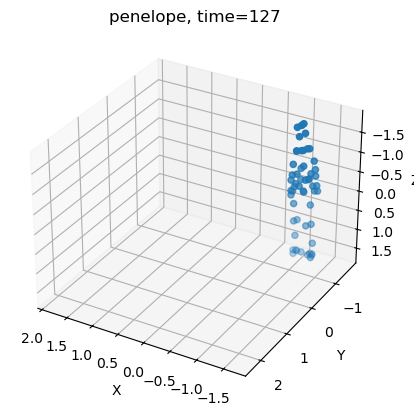

In [166]:
# example usage 
visualize_points(points=points[:, 300:500, :], frames_to_render=128, title='penelope')

Rendered gifs can be found in the `Animations/Raw` folder. These are plots of the raw data found in the .npy files with no data processing done beforehand.

---

### Task 2: Train Generative Model

In [167]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
import torchvision.transforms as T
from glob import glob
import random

Data Cleaning and Preprocessing
- Want to produce standardized data from npy files.
- Interested in predicting 128 timesteps at a time, but we have tensor with dimensions (joints, timesteps, dimensions)
- We choose to preserve spatial dependencies by considering vectors of shape (timesteps, joints * dimensions) as the input for the model.

In [ ]:
#Data augmentation helper function 

def split_and_flatten(data):
    n = data.shape[1]
    num_segments = n - 128
    segments = []
    
    # Seperate each npy file into 128 timestamp regions via sliding window.
    for i in range(num_segments):
        segment = data[:, i:i+128, :]
        segment = segment.transpose((1,0,2))
        segment = segment.reshape(128, 165)
        segment = torch.tensor(segment, dtype=torch.float32)
        segments.append(segment)
    return segments

# Example usage:
# Assuming data is your numpy array with shape (55, n, 3) we seperate and flatten to produce a list of tensors of shape (128, 165) with length n / 128.

In [8]:
# Data loading and processing 

pattern="Data/mariel_*.npy"
ds_list = []

for f in sorted(glob(pattern)):
    ds_name = os.path.basename(f)[7:-4]
    print("loading:", ds_name)
    ds = np.load(f)

    #standardize X and Y dimensions
    ds[:,:,:2] -= ds[:,:,:2].mean(axis=1,keepdims=True)
    ds[:,:,:2] /= ds[:,:,:2].std(axis=1,keepdims=True)
    
    # pad, flatten and add to lsit
    ds_list.extend(split_and_flatten(ds))

loading: betternot_and_retrograde
loading: beyond
loading: chunli
loading: honey
loading: knownbetter
loading: penelope


In [9]:
#Separate Data into Train and Test
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(ds_list, test_size=0.2, random_state=42)

In [10]:
len(X_train)

34832

In [11]:
len(X_test)

8709

In [12]:
X_train[0].shape

torch.Size([128, 165])

In [13]:
# custom dataloader class to assist with batching while training and proper data loading

import torch
from torch.utils.data import Dataset, DataLoader

class TensorListDataset(Dataset):
    def __init__(self, list_of_tensors):
        self.data = list_of_tensors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

# Create an instance of training dataset
training_data = TensorListDataset(X_train)

# Create a DataLoader
dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

#### Model Architechture

We choose to use a VAE LSTM model for reconstruction and generation as it allows for temporal dependencies to be better understood through use of the LSTM layers. Understanding the data that we generated for the model as (128, 165) vectors of shape (timesteps, joints * dimensions), this allows for a very natural procedure for generating and reproducing short fixed-length dance phrases of 128 timesteps.

The reference paper encodes 384 dimensional feature vectors into 256 dimensional feature space and then decodes it back into 384 dimensions. With a 165 dimensional feature vector we thus map into 110 dimensional feature space to consider the same 2/3 ratio.  

Code references for development of the model: 
- https://github.com/CUN-bjy/lstm-vae-torch/blob/main/src/models.py
- https://github.com/Khamies/LSTM-Variational-AutoEncoder/blob/main/model.py
- https://github.com/mariel-pettee/choreography/blob/9bb392306139f162fff51fbd9e9a64e74149eea3/functions/seq_autoencoder.py#L356

In [170]:
#Module of 3 LSTM layers

class LSTM_encode(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_encode, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
    def forward(self, x):
        return self.lstm(x)

class LSTM_decode(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM_decode, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        output, (h, c) = self.lstm(x, hidden)
        prediction = self.fc(output)
        return prediction, (h, c)

# Total VAE LSTM architecture
        
class LSTM_VAE(nn.Module):

    def __init__(self, input_size=165, hidden_size=165, num_layers=3, latent_size=110, output_size=165, device=torch.device('cpu')):
        super(LSTM_VAE, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.output_size = output_size
        self.device = device

        #Encoder
        self.encoder_lstm = LSTM_encode(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        
        #Latent Space Dense Layers
        self.extract_mean = nn.Linear(hidden_size, latent_size)
        self.extract_logvar = nn.Linear(hidden_size, latent_size)
        self.extract_latent = nn.Linear(latent_size, hidden_size)

        #Decoder
        self.decoder_lstm = LSTM_decode(input_size=latent_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def encode(self, x):
        batch_size, seq_len, feature_dim = x.shape

        # encode input space to hidden space
        out, (h, c) = self.encoder_lstm(x)
        enc_h = h[0].view(batch_size, feature_dim).to(self.device)

        return enc_h

    def decode(self, x, mean, logvar):
        
        batch_size, seq_len, feature_dim = x.shape
        
        z = self.reparametize(mean, logvar)  # batch_size x latent_size

        # initialize hidden state as inputs
        h = self.extract_latent(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(self.device)

        # initialize hidden state
        h = torch.stack([h, h, h], dim=0)
        hidden = (h.contiguous(), h.contiguous())
        reconstruct_output, hidden = self.decoder_lstm(z, hidden)

        return reconstruct_output

    def forward(self, x):

        enc_h = self.encode(x)

        mean = self.extract_mean(enc_h)
        logvar = self.extract_logvar(enc_h)
        
        x_hat = self.decode(x, mean, logvar)

        # calculate vae loss
        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)

    def loss_function(self, *args, **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.0001
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

#### Model Training

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [17]:
total_epochs = 1000 #originally set to 1000 this value but only had resources to train for ~400 epochs 
learning_rate = 1e-4

# Initialize model
model = LSTM_VAE().to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

loss_avg, recon_loss_avg, kld_loss_avg = 0, 0, 0
curr_epoch = 0

In [ ]:
#Model training loop

while curr_epoch < total_epochs:

    model.train()

    # Train Autoencoder by passthrough all training data during each epoch
    for t, x in enumerate(dataloader):    
        # Forward Pass and get loss
        x = x.to(device)
        m_loss, x_hat, (recon_loss, kld_loss) = model(x)

        # Backprop
        optimizer.zero_grad()
        m_loss.backward()
        optimizer.step()

        # Record Losses
        loss_avg += m_loss.mean()
        recon_loss_avg += recon_loss
        kld_loss_avg += kld_loss

        if t % 100 == 1:
            print(f'Epoch {curr_epoch}, Iteration: {t},  Loss: {loss_avg/t:1f}, Reconstruction Loss: {recon_loss_avg/t:1f}, KLD Loss: {kld_loss_avg/t:1f}')
    
    if curr_epoch % 100 == 0:
        # Save Model parameters every 100 epochs
        torch.save(model.state_dict(), f'model_parameters_{curr_epoch}.pth')
    
    loss_avg, recon_loss_avg, kld_loss_avg = 0, 0, 0
    curr_epoch += 1

#### Load Trained Model and Reconstruct Sequences from the Test Set

The model was trained on CUDA enabled GPU for ~400 epochs. 

We first take a data observation from the test set that was not seen by the model and use the LSTM VAE model to encode and decode the sequence.

In [171]:
# Load models 
model = LSTM_VAE().to(device)
model.load_state_dict(torch.load('Parameters/model_parameters_400.pth', map_location=torch.device('cpu')))
model.eval()

LSTM_VAE(
  (encoder_lstm): LSTM_encode(
    (lstm): LSTM(165, 165, num_layers=3, batch_first=True)
  )
  (extract_mean): Linear(in_features=165, out_features=110, bias=True)
  (extract_logvar): Linear(in_features=165, out_features=110, bias=True)
  (extract_latent): Linear(in_features=110, out_features=165, bias=True)
  (decoder_lstm): LSTM_decode(
    (lstm): LSTM(110, 165, num_layers=3, batch_first=True)
    (fc): Linear(in_features=165, out_features=165, bias=True)
  )
)

In [51]:
# Try and reproduce dance that was not seen in the test set
unseen_dance = X_test[1].unsqueeze(0)
_, reproduce_dance, _ = model(unseen_dance)

In [52]:
# Reshape unseen dance and reproduced dance which allows produce visualizations
unseen_dance_reshaped = X_test[1].numpy().reshape(128, 55, 3).transpose((1,0,2))
reproduced_dance_reshaped = reproduce_dance.squeeze(0).detach().numpy().reshape(128, 55, 3).transpose((1,0,2))

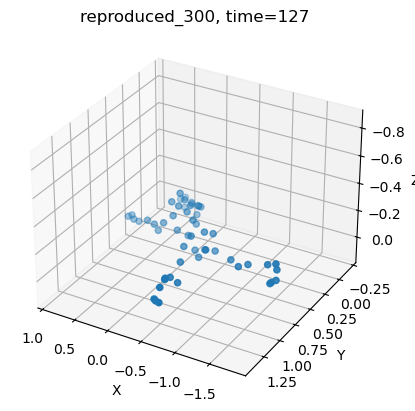

In [54]:
visualize_points(points=reproduced_dance_reshaped, standardize=False, title='reproduced_400')

Rendered gifs of the reconstructed sequences be found in the `Animations/Reproduced` folder.  

The naming scheme is `reproduced_xxx.gif` where `xxx` denotes the epoch number of the model parameters that were saved. The visualized data from the test set is named `unseen.gif`.

#### Generating Dance Sequences

Here were choose random mean and variance in the latent space to produce novel dance sequences with the model.

In [145]:
unseen_dance = X_test[0].unsqueeze(0)
enc_h = model.encode(unseen_dance)
mean = model.extract_mean(enc_h)
logvar = model.extract_logvar(enc_h)

In [146]:
rand_mean = torch.rand(mean.shape)
rand_logvar = torch.rand(logvar.shape)

In [147]:
generated_dance = model.decode(unseen_dance, rand_mean, rand_logvar)

In [148]:
generated_dance_reshaped = generated_dance.squeeze(0).detach().numpy().reshape(128, 55, 3).transpose((1,0,2))

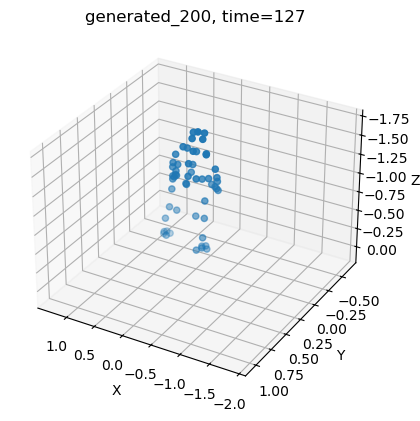

In [150]:
visualize_points(points=generated_dance_reshaped, standardize=False, title='generated_200')

Rendered gifs can be found in the `Animations/Generated` folder. The selected gifs are generated sequences I personally found interesting.

The naming scheme is `generated_xxx.gif` where `xxx` denotes the epoch number of the model parameters that were saved.

---

### Task 3: Why this project?

I am drawn to this project by the opportunity to blend my academic expertise with my love for dance, exploring innovative ways to push the boundaries of dance with AI.

I recently completed my undergraduate degree in both Computer Science and Economics majors at the University of Chicago along with specializations in Machine Learning and Data Science.  I am currently enrolled in the University’s Financial Mathematics Master’s Program which is set to begin in Fall 2024. 

At the start of college I also began dancing with UChicago’s neXus Dance Collective. As a result I’ve had many opportunities to learn, teach and perform a variety of choreographies from the genre of K-Pop dance. Recently I’ve been learning street-dance styles like krump, hip-hop and more. You can frequently catch me walking down the street with my earbuds in practicing choreography or freestyling. I plan to continue dancing until I can’t anymore.

In and out of class I enjoy leveraging machine learning as a tool for solving interesting problems. Some projects I’ve worked on include multi-class named entity recognition with large language models, malware detection in network data with weighted ensemble models, implementation of CycleGAN for image-to-image translation between human and anime selfies, and more. I hope to continue exploring novel uses of machine learning throughout my career, if possible.

One idea that comes to mind for modeling duets is the use of generative adversarial networks (GANs). Particularly, advancements such as [conditional GANS](https://arxiv.org/pdf/1411.1784.pdf) (cGANs) and [time-series GANS](https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf) (TimeGAN) appear promising. The current TimeGAN architechture considers vector spaces $\mathcal{S}$ of static features and $\mathcal{X}$ of temporal features tries to learn joint density $\hat{p}(\boldsymbol{S},\boldsymbol{X}_{1:T})$ where $\boldsymbol{S} \in \mathcal{S}$ and $\boldsymbol{X} \in \mathcal{X}$ are random vectors that take realizations $\boldsymbol{s}$ and $\boldsymbol{x}$. 

Through an abstract understanding of the model, I wonder if it is possible to consider the joint probability between two sets of temporal features (which would be the two dancers in the duet) we can try to train a generator that takes in random noise input conditioned on the temporal features of one dancer to produce a dance sequence of the second dancer for the duet. I have not dived into the mathematical feasibility of such a model, but I am open to exploring this direction and any other suggested directions.

Regarding AI's role in art, while I believe that currently there will always be some human ingenuity that cannot be captured by AI, I do believe that AI can be a valuable tool in the art creation process as a sounding board for ideas. However, I am cognizant of ethical considerations, especially concerning systemic biases in training data and intellectual property concerns regarding training data. Overall, I would be excited to contribute to HumanAI's mission of advancing AI use in humanist interests while remaining mindful of the aforementioned ethical implications and the intrinsic value of human expression in art.